# Density of States 3D Example
This notebook computes the density of states for the same example gyroid system shown in the original Scheme/MATLAB implementation.
The parameters used for computing the density of states and plotting variables are chosen to match the example plot in the original implementation.

This notebook imports material properties from `material.py`, integrator routines from `integrators.py`, and utility functions/classes from `util.py`, so those files must be contained in the same directory.
Please refer to those files for docstrings and citation information where applicable.

Both the tetrahedron (Tr) and Generalized Gilat-Raubenheimer (GGR) methods are used to determine the density of states.

In [1]:
import os
from contextlib import redirect_stdout
from functools import partial

import ase
import matplotlib.pyplot as plt
import meep
import numpy as np
from meep import mpb
from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.concurrent import process_map

from integrators import ggr_integration, tetrahedron_integration
from material import (
    default_material,
    eps_func,
    gyroid_material,
    k_point_band_path,
    k_point_interpolation,
    k_point_labels,
    k_point_sequence,
    lattice,
)
from util import TqdmWrappedIterable, _array_to_vec3s

Choose parameters for MPB and evaluate the bands over the k-path defined in `material.py`.

In [2]:
resolution = 16
mesh_size = 2
num_bands = 20

In [3]:
k_path_solver = mpb.ModeSolver(
    resolution=resolution,
    mesh_size=mesh_size,
    num_bands=num_bands,
    k_points=TqdmWrappedIterable(k_point_band_path),
    default_material=default_material,
    geometry_lattice=lattice,
)
k_path_solver.verbose = False

In [4]:
with open("mpb_output_band_path.txt", "w") as mpb_out, redirect_stdout(mpb_out):
    k_path_solver.run()

Plot the band structure.

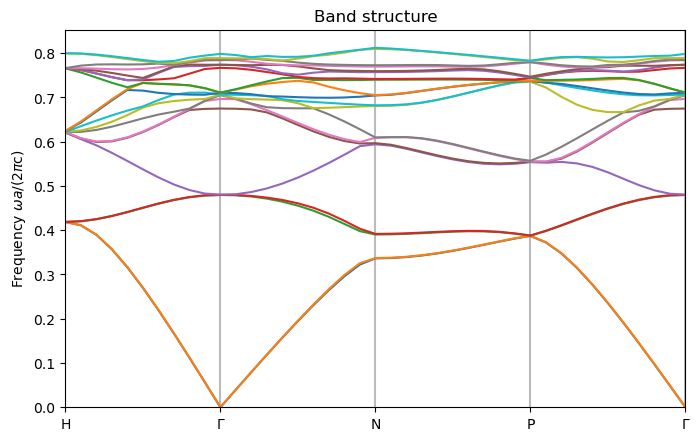

In [5]:
plt.figure(figsize=(8, 5), dpi=100)
labels_x = np.arange(len(k_point_labels)) * k_point_interpolation
plt.xticks(ticks=labels_x, labels=k_point_labels)
for x in labels_x:
    plt.axvline(x, color="#bbb")
for i in range(k_path_solver.all_freqs.shape[1]):
    plt.plot(k_path_solver.all_freqs[:, i])
plt.title("Band structure")
plt.ylabel("Frequency $\omega a$/(2$\pi$c)")
plt.ylim(0, np.max(k_path_solver.all_freqs) * 1.05)
plt.xlim(0, np.max(labels_x))
plt.savefig("band_structure.png")
plt.show()

Determine k-points for evaluating the density of states.

In [6]:
num_points = (10, 10, 10)
for x in num_points:
    assert x % 2 == 0
k_points = _array_to_vec3s(ase.dft.kpoints.monkhorst_pack(num_points))

Here, we provide `append_velocities` as a "band function." Band functions must be callables with only one argument, the `ModeSolver` instance. In an ideal world, I would prefer to use a method of a class, or even a callable class instance, but MPB does some kind of Python introspection on the provided function that prevents those approaches from working. Instead, we create a function `append_velocities` that binds a variable `velocities` from outside the function scope and appends the group velocities for each k-point as the `ModeSolver` evaluates them. Finally, we use `velocities_as_array` to convert the group velocites into a NumPy array.

See the MPB docs for additional information about running with a band function: https://mpb.readthedocs.io/en/latest/Python_User_Interface/#run-functions

In [7]:
def append_velocities(solver):
    velocities.append(solver.compute_group_velocities())


def velocities_as_array():
    return np.asarray([[[v[0], v[1], v[2]] for v in band] for band in velocities])


solver = mpb.ModeSolver(
    resolution=resolution,
    mesh_size=mesh_size,
    num_bands=num_bands,
    k_points=TqdmWrappedIterable(k_points),
    default_material=default_material,
    geometry_lattice=lattice,
)
solver.verbose = False

In [8]:
velocities = []
with open("mpb_output.txt", "w") as mpb_out, redirect_stdout(mpb_out):
    solver.run(append_velocities)
velocities = velocities_as_array()

The tetrahedron integration method performs best if the tetrahedra are formed by splitting along the shortest cell diagonal. This cell arranges the frequencies in an order with the shortest diagonal.

In [9]:
reciprocal_vectors = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
diagonal_lengths = np.array(
    [
        np.linalg.norm(reciprocal_vectors @ [1, 1, 1]),
        np.linalg.norm(reciprocal_vectors @ [-1, 1, 1]),
        np.linalg.norm(reciprocal_vectors @ [1, -1, 1]),
        np.linalg.norm(reciprocal_vectors @ [1, 1, -1]),
    ]
)
min_diagonal_length = np.argmin(diagonal_lengths)
w_grid = solver.all_freqs.reshape(num_points + (num_bands,))
w_grid = np.flip(w_grid, axis=min_diagonal_length)

Perform the tetrahedron integration.

In [10]:
w_bins_Tr, DOS_Tr = tetrahedron_integration(
    num_points, num_bands, w_grid, w_min=0, w_max=None, num_bins=20000
)

Perform the Generalized Gilat-Raubenheimer integration.

In [11]:
w_bins_ggr, DOS_ggr = ggr_integration(
    num_points, solver.all_freqs, velocities, num_bins=20000
)

Plot the densities of states obtained from each integration method.

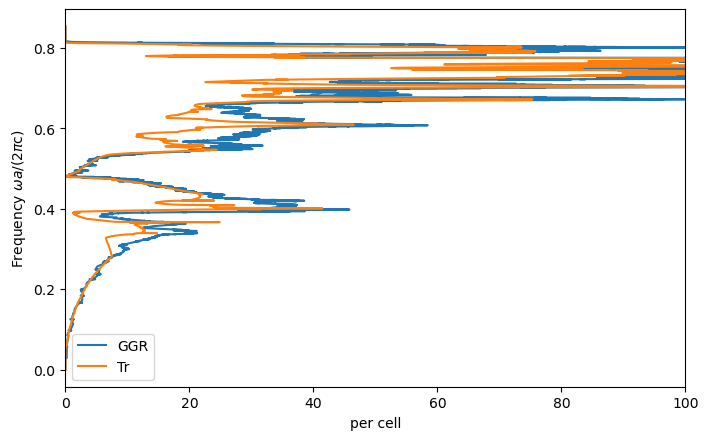

In [12]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(DOS_ggr, w_bins_ggr, label="GGR")
plt.plot(DOS_Tr, w_bins_Tr, label="Tr")
plt.xlim(0, 100)
plt.xlabel("per cell")
plt.ylabel("Frequency $\omega a$/(2$\pi$c)")
plt.legend()
plt.savefig("density_of_states.png")
plt.show()

Plot the band structure and GGR density of states.

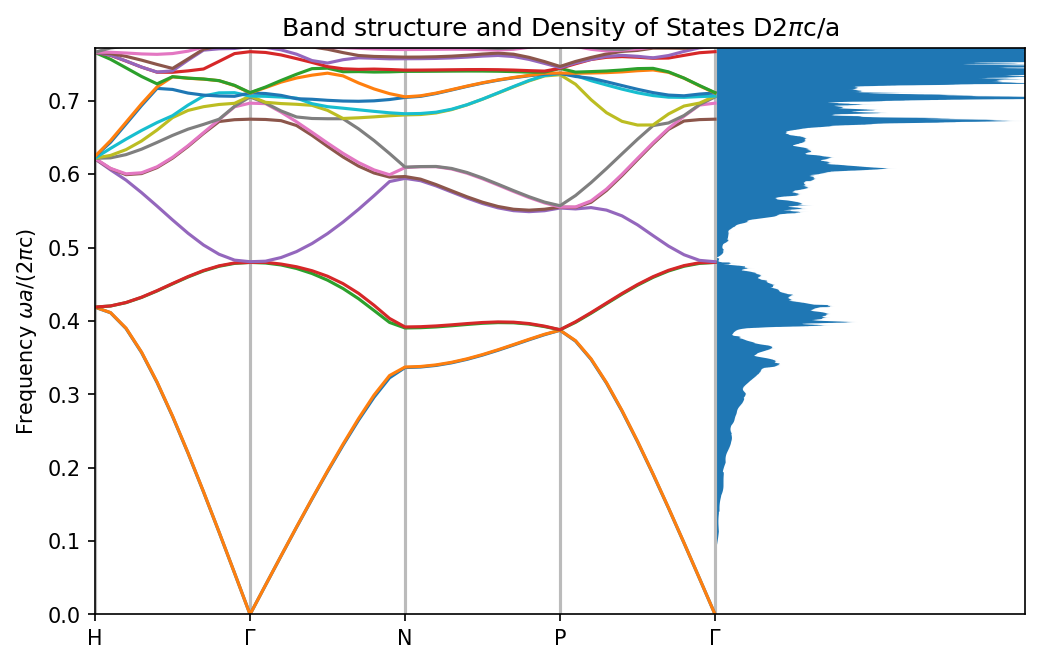

In [13]:
plt.figure(figsize=(8, 5), dpi=150)
labels_x = np.arange(len(k_point_labels)) * k_point_interpolation
plt.xticks(ticks=labels_x, labels=k_point_labels)
for x in labels_x:
    plt.axvline(x, color="#bbb")
for i in range(k_path_solver.all_freqs.shape[1]):
    plt.plot(k_path_solver.all_freqs[:, i])
x_start_dos = (len(k_point_labels) - 1) * k_point_interpolation
dos_width = 2 * k_point_interpolation / 100
plt.gca().fill_betweenx(w_bins_ggr, x_start_dos, x_start_dos + DOS_ggr * dos_width)
plt.xlim(0, x_start_dos + dos_width * 100)
plt.title("Band structure and Density of States D2$\pi$c/a")
plt.ylabel("Frequency $\omega a$/(2$\pi$c)")
plt.ylim(0, np.max(k_path_solver.all_freqs) * 0.95)
plt.savefig("band_structure_and_density_of_states.png")
plt.show()